In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional,Concatenate, Dropout,GRU
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer, MaxScoreTokenizer
from soynlp.normalizer import *
from keras.models import load_model
import pickle
import os 
from gensim import corpora
os.chdir("..\data")

In [3]:
file_name = "comment.xlsx"
comment = pd.read_excel(file_name)
ad =  pd.read_excel("clean_ad.xlsx")


In [4]:
comment = np.array(comment["comment"])
advertise = np.array(ad["comment"])
com_len = len(comment)
ad_len = len(advertise)
y_data = np.array([0]*com_len+[1]*ad_len)
comments = np.concatenate([comment,advertise])
df = pd.DataFrame(comments, columns=["comment"])

In [5]:
# 불용어 정의
df['comment'] = df['comment'].str.replace(".","")                         # .이나 _먼저 공백으로
df['comment'] = df['comment'].str.replace("_", "")
df['comment'] = df['comment'].str.replace("\W"," ")                    # 특수문자 제거.
df['comment'] = df['comment'].str.replace("체널|쳬널|챼널|채녈|체녈|쳬녈|챼녈", "채널") # 채널 단어 정규화
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','데',"게","꽤", "면", "로"]


In [6]:
# Okt를 사용한 전처리.
my_okt = Okt()
X_data = []
word2index={}  
bow=[]  
for a_sent in df['comment']:
#     print(a_sent)
    a_sent = emoticon_normalize(a_sent, num_repeats=2)
    a_sent = repeat_normalize(a_sent, num_repeats=2)
    a_sent_tokenized = my_okt.morphs(a_sent, stem=True)                    # 어간추출 적용 토큰화.
    a_sent_tokenized = [a_word for a_word in a_sent_tokenized if not a_word in stopwords] # 불용어 제거.
    
#     a_sent_tokenized = my_okt.nouns(a_sent)                               # 명사만.
    
    X_data.append(a_sent_tokenized)

In [7]:
for x in X_data:
    
    print(x)

['명수', '님', '은지', '언니', '한테', '세뱃돈', '주다', '감사하다', '은지', '언니', '라', '방', '에서', '세뱃돈', '고이', '모시다', '두다', 'ㅋㅋ', '미산', '장', 'amp', '쿨', '에프', '앰', '케미', '기대하다']
['아', '너무', '재밌다', '보다', '웃기다', '죽다', 'ㅋㅋ', '독', '꾹', '누르다', '감', '명수', '유튜브', '응원']
['헐트', '오브', '광어', '어', '억', '어디가', '쏘다', 'ㅠ']
['오다', '조합', '보고', '좋다', '욕', '나', '올', '뻔']
['a', 'href', 'https', 'wwwyoutubecom', 'watch', 'v', 'tXDgODuch', '94', 'amp', 't', '0', 'm', '54', 's', '0', '54', 'a', 'br', 'ㅋㅋ', '역시', '거성']
['저', '게스트', '아주머니', '유튜버신가', '요']
['a', 'href', 'https', 'wwwyoutubecom', 'watch', 'v', 'tXDgODuch', '94', 'amp', 't', '0', 'm', '00', 's', '0', '00', 'a', '이다', '킹', 'point']
['빙수', '언니', '한복', '곱다']
['예능', '유투', '버', '1등', '되다']
['헐트', '오브', '명수', 'ㅋㅋ', '수', '빙수', '님', '영상', '항상', '나오다', 'ㅋㅋ']
['옛날', '에는', '아들', '태어나다', '딸', '키우다', '딸', '없다', '자식', '취급', '영아', '사망', '율', '높다', '아기', '때', '죽다', '경우', '많다', 'br', 'br', '딸', '태어나다', '납치', '당하다', '남자', '키우다', '한다는', '일본', '만화가', '많다', '전투', '적', '인', '여', '전사', '섹

In [8]:
# Integer Encoding 학습 실시!
vocab_size = 2000
my_tokenizer = Tokenizer(num_words= vocab_size)
my_tokenizer.fit_on_texts(X_data) 

In [9]:
X_data = my_tokenizer.texts_to_sequences(X_data)

리뷰의 최대 길이 : 2046
리뷰의 평균 길이 : 18.608247422680414


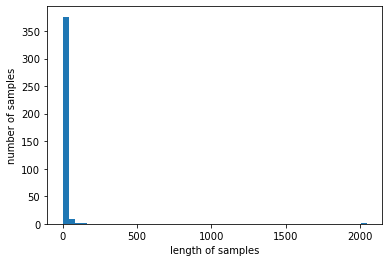

In [10]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_data))
print('리뷰의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 길이 2000인 값 때문에 그래프 식별이 어려움

In [11]:
max_data = np.array([len(l) for l in X_data]).argmax()
print(np.array([len(l) for l in X_data]).argmax()) #가장 긴 문장의 위치 파악

359


리뷰의 최대 길이 : 130
리뷰의 평균 길이 : 13.369509043927648


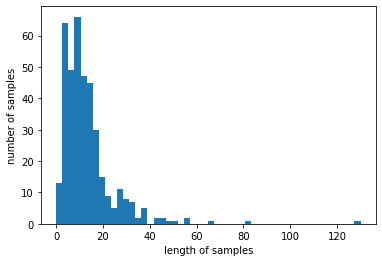

In [12]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_data[:max_data]+X_data[max_data+1:]))
print('리뷰의 평균 길이 :',sum(map(len, X_data[:max_data]+X_data[max_data+1:]))/len(X_data[:359]+X_data[360:]))
plt.hist([len(s) for s in X_data[:max_data]+X_data[max_data+1:]], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [14]:
max_len = 50
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.19587628865979


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1234)

In [16]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [17]:
n_hidden = 128                   # 개개 memory cell 안의 neuron 수.
n_emb = 100    

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(n_hidden))
model.add(Dense(1, activation='sigmoid'))

In [19]:
learn_rate = 0.00001               # learning rate. 

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es,mc], batch_size=64, validation_split=0.2)

Epoch 1/20
1/4 [======>.......................] - ETA: 0s - loss: 0.6931 - acc: 0.5312
Epoch 00001: val_acc improved from -inf to 0.54839, saving model to best_model.h5
4/4 [==============================] - 1s 186ms/step - loss: 0.6895 - acc: 0.6169 - val_loss: 0.6852 - val_acc: 0.5484
Epoch 2/20
1/4 [======>.......................] - ETA: 0s - loss: 0.6763 - acc: 0.6875
Epoch 00002: val_acc did not improve from 0.54839
4/4 [==============================] - 0s 15ms/step - loss: 0.6692 - acc: 0.6452 - val_loss: 0.6729 - val_acc: 0.5161
Epoch 3/20
1/4 [======>.......................] - ETA: 0s - loss: 0.6648 - acc: 0.5938
Epoch 00003: val_acc improved from 0.54839 to 0.69355, saving model to best_model.h5
4/4 [==============================] - 0s 21ms/step - loss: 0.6284 - acc: 0.7379 - val_loss: 0.6379 - val_acc: 0.6935
Epoch 4/20
1/4 [======>.......................] - ETA: 0s - loss: 0.5934 - acc: 0.8281
Epoch 00004: val_acc did not improve from 0.69355
4/4 [=========================

In [22]:
# os.chdir("..\data")
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

3/3 [==============================] - 0s 4ms/step - loss: 0.3903 - acc: 0.8974

 테스트 정확도: 0.8974


In [23]:
import tensorflow as tf
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
my_model = Model(inputs=sequence_input, outputs=output)
my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [25]:
history = my_model.fit(X_train, y_train, epochs = 9,batch_size = 32, verbose=1)

Epoch 1/9
10/10 [==============================] - 4s 361ms/step - loss: 0.6926 - accuracy: 0.5548
Epoch 2/9
10/10 [==============================] - 4s 360ms/step - loss: 0.6845 - accuracy: 0.6710
Epoch 3/9
10/10 [==============================] - 4s 378ms/step - loss: 0.5797 - accuracy: 0.7516
Epoch 4/9
10/10 [==============================] - 4s 381ms/step - loss: 0.3746 - accuracy: 0.9323
Epoch 5/9
10/10 [==============================] - 4s 370ms/step - loss: 0.3467 - accuracy: 0.9742
Epoch 6/9
10/10 [==============================] - 4s 364ms/step - loss: 0.2117 - accuracy: 0.9871
Epoch 7/9
10/10 [==============================] - 4s 359ms/step - loss: 0.1498 - accuracy: 0.9903
Epoch 8/9
10/10 [==============================] - 4s 372ms/step - loss: 0.0699 - accuracy: 0.9968
Epoch 9/9
10/10 [==============================] - 4s 359ms/step - loss: 0.0532 - accuracy: 1.0000


In [26]:
print("\n 테스트 정확도: %.4f" % (my_model.evaluate(X_test, y_test)[1]))

3/3 [==============================] - 0s 21ms/step - loss: 0.8513 - accuracy: 0.8333

 테스트 정확도: 0.8333


In [41]:
def ad_predict(a_sentence):
    a_sentence = emoticon_normalize(a_sentence, num_repeats=2)
    a_sentence = repeat_normalize(a_sentence, num_repeats=2)
    a_sentence = my_okt.morphs(a_sentence, stem=True) # 토큰화
    a_sentence = [a_word for a_word in a_sentence if not a_word in stopwords] # 불용어 처리.
    a_sentence_encoded = my_tokenizer.texts_to_sequences([a_sentence]) # 정수 인코딩.
    X_new = pad_sequences(a_sentence_encoded, maxlen = max_len)     # Padding.
    
    
    a_score = float(loaded_model.predict(X_new))                      # 예측.
#     a_score = (float(my_model.predict(X_new))+float(loaded_model.predict(X_new)) )/2
    if(a_score > 0.5):
        print("광고 댓글일 가능성 = {:.2f}%.\n".format(a_score * 100))
    else:
        print("정상 댓글일 가능성 = {:.2f}%.\n".format((1 - a_score) * 100))

In [44]:
ad_predict("자신들은 학폭을 수없이 해왔으면서 한번의 용서로 끝을 맺으려하네 진짜 양심없다 그러니 인성이 저러지")

정상 댓글일 가능성 = 74.96%.



In [45]:
ad_predict("제목보 고 안믿겨서 호다닥 들어왔습니다 기안과 함께는 진짜 귀하군요...")

정상 댓글일 가능성 = 90.39%.



In [46]:
ad_predict("김태리 진짜 미스터 션사인 보고 봐서 그런지 조선시대 최고 미녀 같애....... 블링블링한 이쁨이 아니라 성숙하게 아름다움")

정상 댓글일 가능성 = 98.49%.



In [48]:
ad_predict("제 체널 지금 바로 오시면 돈 드립니다")

광고 댓글일 가능성 = 99.07%.



In [49]:
ad_predict("BJ 충격 영상 제 프로필 오시면 볼 수 있어요")

광고 댓글일 가능성 = 99.64%.



In [50]:
ad_predict("ㅂㅏㅋㅏㄹㅏ ㅋㅏㅈㅣㄴ 지금 가입하면 쿠폰 드림")

광고 댓글일 가능성 = 95.73%.



In [51]:
ad_predict("ㅋr ㅈ i ㄴ 접속하면 바로 혜택")

광고 댓글일 가능성 = 99.60%.



In [52]:
ad_predict("ㅁrㅋ롱 ㅌㅣㅂㅣ 개쩐다 내 프로필 클릭")

광고 댓글일 가능성 = 97.31%.



In [53]:
ad_predict("마ㅋㅏㄹㅗㅇㅌㅣㅂㅣ 우리 삼촌도 여기보던데")

정상 댓글일 가능성 = 96.67%.



In [39]:
ad_predict("저국물에 밥을 넣어 푹끓여 된장죽밥드심 다시 술시작할수 있는데~~ㅎ")

정상 댓글일 가능성 = 71.00%.

